# `Keras`

[Keras](https://keras.io/) is a high-level neural networks API, written in Python and capable of running on top of [TensorFlow](https://www.tensorflow.org/), [CNTK](https://docs.microsoft.com/de-de/cognitive-toolkit/), or [Theano](http://www.deeplearning.net/software/theano/). It was developed with a focus on enabling fast experimentation. *Being able to go from idea to result with the least possible delay is key to doing good research.*

**Note 1:** This is not an introduction to deep neural networks as this would explode the scope of this notebook. But we want to show you how you can implement a convoluted neural network to classify neuroimages, in our case fMRI images.  
**Note 2:** We want to thank [Anisha Keshavan](https://github.com/akeshavan) as a lot of the content in this notebook is coming from here [introduction notebook](http://nbviewer.jupyter.org/github/brainhack101/IntroDL/blob/master/IntroToKeras.ipynb) about Keras.

## Setup

In [1]:
%matplotlib inline
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

## Load machine learning dataset

Let's again load the dataset we prepared in the machine learning preparation notebook, plus the anatomical template image (we will need this for visualization).

In [2]:
anat = nb.load('/templates/MNI152_T1_1mm.nii.gz')
func = nb.load('/home/neuro/notebooks/data/dataset_ML.nii.gz')

In [3]:
from nilearn.image import mean_img
from nilearn.plotting import plot_anat

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/miniconda-latest/envs/neuro/lib/py

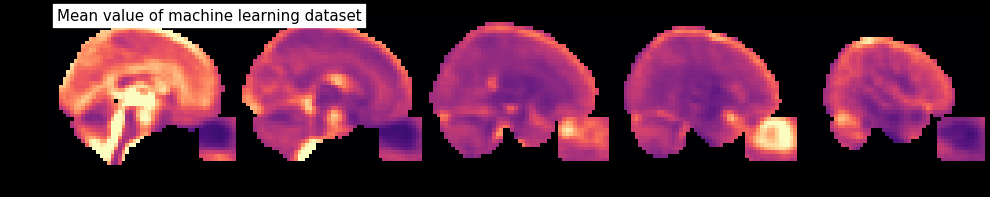

In [4]:
plot_anat(mean_img(func), cmap='magma', colorbar=False, display_mode='x', vmax=2, annotate=False,
          cut_coords=range(0, 49, 12), title='Mean value of machine learning dataset');

As a reminder, the shape of our machine learning dataset is as follows:

In [5]:
func.shape

(40, 51, 41, 384)

# Specifying labels and chunks

As in the `nilearn` and `PyMVPA` notebook, we need some chunks and label variables to train the neural network. The labels are important, so that we can predict what we want to classify. And the chunks are just an eady way to make sure that the training and test dataset are split in an equal/balanced way.

So, as before, we specify again which volumes of the dataset were recorded during eyes **closed** resting state and which ones were recorded during eyes **open** resting state recording.

From the [Machine Learning Preparation](machine_learning_preparation.ipynb) notebook, we know that we have a total of 384 volumes in our `dataset_ML.nii.gz` file and that it's always 4 volumes of the condition `eyes closed`, followed by 4 volumes of the condition `eyes open`, etc. Therefore our labels should be as follows:

In [6]:
labels = np.ravel([[['closed'] * 4, ['open'] * 4] for i in range(48)])
labels[:20]

array(['closed', 'closed', 'closed', 'closed', 'open', 'open', 'open',
       'open', 'closed', 'closed', 'closed', 'closed', 'open', 'open',
       'open', 'open', 'closed', 'closed', 'closed', 'closed'],
      dtype='<U6')

***Second***, the `chunks` variable should not switch between subjects. So, as before, we can again specify 6 chunks of 64 volumes (8 subjects), each:

In [7]:
chunks = np.ravel([[i] * 64 for i in range(6)])
chunks[:150]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# Keras 2D Example

Convoluted neural networks are very powerful (as you will see), but the computation power to train the models can be incredibly demanding. For this reason, it's sometimes recommended to try to reduce the input space if possible.

In our case, we could try to not train the neural network only on one very thin slab (a few slices) of the brain. So, instead of taking the data matrix of the whole brain, we just take 3 slices in the region that we think is most likely to be predictive for the question at hand.

We know (or suspect) that the regions with the most predictive power are probably somewhere around the eyes and in the visual cortex. So let's try to specify a few slices that cover those regions.

So, let's try to just take a few slices around the eyes:

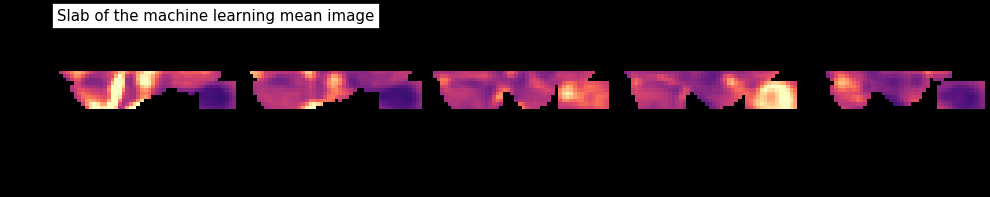

In [8]:
plot_anat(mean_img(func).slicer[...,5:-25], cmap='magma', colorbar=False,
          display_mode='x', vmax=2, annotate=False, cut_coords=range(0, 49, 12),
          title='Slab of the machine learning mean image');

Hmm.. That doesn't seem to work. We want the eyes and the visual cortex. In the back of the brain, we're too far down in the cerebellum. Let's rotate the volume:

In [9]:
# Rotation parameters
phi = 0.35
cos = np.cos(phi)
sin = np.sin(phi)

# Compute rotation matrix
rotation_affine = np.array([[1, 0, 0, 0],
                            [0, cos, -sin, 0],
                            [0, sin, cos, 0],
                            [0, 0, 0, 1]])

# Rotate and resample image to new orientation
from nilearn.image import resample_to_img
new_affine = rotation_affine.dot(func.affine)
new_img = nb.Nifti1Image(func.get_fdata(), new_affine, func.header)
img_rot = resample_to_img(new_img, func)

Let's check if the rotation worked.

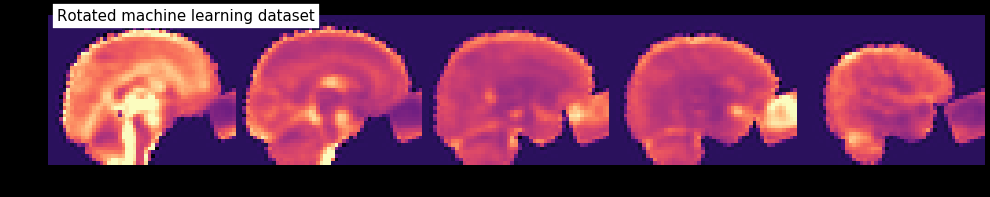

In [10]:
plot_anat(mean_img(img_rot), cmap='magma', colorbar=False, display_mode='x', vmax=2, annotate=False,
          cut_coords=range(0, 49, 12), title='Rotated machine learning dataset');

Perfect! And which slab should we take? Let's try the slices 13 to 15.

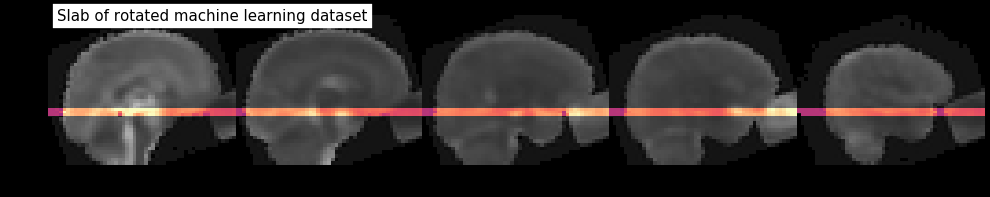

In [11]:
from nilearn.plotting import plot_stat_map
img_slab = img_rot.slicer[..., 13:16, :]
plot_stat_map(mean_img(img_slab), cmap='magma', bg_img=mean_img(img_rot), colorbar=False,
              display_mode='x', vmax=2, annotate=False, cut_coords=range(0, 49, 12),
              title='Slab of rotated machine learning dataset');

Perfect, the slab seems to contain exactly what we want. Now that the data is ready we can continue with the actual machine learning part.

## Split data into a training and testing set

First things first, we need to define a training and testing set. This is *really* important, because we need to make sure that our model can generalize to new, unseen data. Here, we randomly shuffle our data, and reserve 80% of it for our training data, and the remaining 20% for testing.

So let's first get the data in the right structure for keras. For this, we need to swap some of the dimensions of our data matrix.

In [12]:
data = np.rollaxis(img_slab.get_fdata(), 3, 0)
data.shape

(384, 40, 51, 3)

As you can see, the goal is to have in the first dimension, the different volumes, and than the volume itself. Keep in mind, that the last dimension (here of size 3), are considered as `channels` in the keras model that we will be using below.

As a next step, let's create a index list that we can use to split the data and labels into training and test sets:

In [13]:
# Create list of indices and shuffle them
N = data.shape[0]
indices = np.arange(N)
np.random.shuffle(indices)

#  Cut the dataset at 80% to create the training and test set
N_80p = int(0.8 * N)
indices_train = indices[:N_80p]
indices_test = indices[N_80p:]

# Split the data into training and test sets
X_train = data[indices_train, ...]
X_test = data[indices_test, ...]

print(X_train.shape, X_test.shape)

(307, 40, 51, 3) (77, 40, 51, 3)


## Create outcome variable

We need to define a variable that holds the outcome variable (1 or 0) that indicates whether or not the resting-state images were recorded with eyes opened or closed. Luckily we have this information already stored in the `labels` variable above. So let's split these labels in training and test set:

In [14]:
y_train = labels[indices_train] == 'open'
y_test = labels[indices_test] == 'open'

We need to reformat the shape of our outcome variables, `y_train` and `y_test`, because Keras needs the labels as a 2D array. Keras provides a function to do this:

In [15]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Using TensorFlow backend.


And now we're good to go.

## Creating a Sequential Model

Now comes the fun and tricky part. We need to specify the structure of our convoluted neural network. As a quick reminder, a convoluted neural network consists of some covolution layers, pooling layers, some flattening layers and some full connect layers:

<img src="data/deep_neural_networks.png"/>

Taken from: https://www.mathworks.com/videos/introduction-to-deep-learning-what-are-convolutional-neural-networks--1489512765771.html

So as a first step, let's import all modules that we need to create the keras model:

In [ ]:
import tensorflow as tf
from keras.models import Sequential

from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from keras.optimizers import Adam, SGD

from keras import backend as K

As a next step, we should specify some of the model parameters that we want to be identical throughout the model:

In [ ]:
# Get shape of input data
data_shape = tuple(X_train.shape[1:])

# Specify shape of convolution kernel
kernel_size = (3, 3)

# Specify number of output categories
n_classes = 2

# Specify number of filters per layer
filters = 16

Now comes the big part... the model, i.e. the structure of the neural network! We want to make clear that we're no experts in deep neural networks and therefore, the model below might not necessarily be a good model. But we chose it as it can be rather quickly estimated and has rather few parameters to estimate.

In [ ]:
K.clear_session()
model = Sequential()

model.add(Conv2D(filters, kernel_size, activation='relu', input_shape=data_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(filters * 2, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(filters * 4, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(filters * 8, kernel_size, activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(n_classes, activation='softmax'))

# optimizer
learning_rate = 1e-5
adam = Adam(lr=learning_rate)
sgd = SGD(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=adam, # swap out for sgd 
              metrics=['accuracy'])

model.summary()

That's what our model looks like! Cool!

## Fitting the Model

The next step is now of course to fit our model to the training data. In our case we have two parameters that we can work with:

*First*: How many iterations of the model fitting should be computed

In [ ]:
nEpochs = 200

*Second*: How many elements (volumes) should be considered at once for the updating of the weights?

In [ ]:
batch_size = 16

So let's test the model:

In [ ]:
%time fit = model.fit(X_train, y_train, epochs=nEpochs, batch_size=batch_size)

## Performance during model fitting

Let's take a look at the loss and accuracy values during the different epochs:

In [ ]:
fig = plt.figure(figsize=(10, 4))
epoch = np.arange(nEpochs) + 1
fontsize = 16
plt.plot(epoch, fit.history['acc'], marker="o", linewidth=2,
         color="steelblue", label="accuracy")
plt.plot(epoch, fit.history['loss'], marker="o", linewidth=2,
         color="orange", label="loss")
plt.xlabel('epoch', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16);

Great, it seems that accuracy is constantly increasing and the loss is continuing to drop. But how well is our model doing on the test data?

## Evaluating the model

In [ ]:
evaluation = model.evaluate(X_test, y_test)
print('Loss in Test set:      %.02f' % (evaluation[0] * 100))
print('Accuracy in Test set:  %.02f' % (evaluation[1] * 100))

What are the predicted values of the test set?

In [ ]:
y_pred = model.predict(X_test)
y_pred[:10,:]

As you can see, those values can be between 0 and 1.

In [ ]:
fig = plt.figure(figsize=(6, 4))
fontsize = 16
plt.hist(y_pred[:,0], bins=16, label='eyes closed')
plt.hist(y_pred[:,1], bins=16, label='eyes open');
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16);

The more both distributions are distributed around chance level, the weaker your model is.

**Note:** Keep in mind that we trained the whole model only on one split of test and training data. Ideally you would repeat this process many times, so that your results become less dependent on what kind of split you did.

## Visualizing Hidden Layers

Finally, as a cool additional feature: We can now visualize the individual filters of the hidden layers. So let's get to it:

In [ ]:
# Aggregate the layers
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [ ]:
# Specify a function that visualized the layers
def show_activation(layer_name):
    
    layer_output = layer_dict[layer_name].output

    fn = K.function([model.input], [layer_output])
    
    inp = X_train[0:1]
    
    this_hidden = fn([inp])[0]
    
    # plot the activations, 8 filters per row
    plt.figure(figsize=(16,8))
    nFilters = this_hidden.shape[-1]
    for i in range(nFilters):
        plt.subplot(nFilters/8, 8, i+1)
        plt.imshow(this_hidden[0,:,:,i], cmap='magma', interpolation='nearest')
        plt.axis('off')
    
    return 

Now we can plot the filters of the hidden layers:

In [ ]:
show_activation('conv2d_1')

In [ ]:
show_activation('conv2d_2')

In [ ]:
show_activation('conv2d_3')

## Conclusion of 2D example

The classification of the training set get's incredible high, while the validation set also reaches a reasonable accuracy level above 80. Nonetheless, by only investigating a slab of our fMRI dataset, we might have missed out on some important additional paramters.

An alternative solution might be to use 3D convoluted neural networks. But keep in mind that they will have even more parameters and probably take much longer to fit the model to the training data. Having said so, let's get to it.

# Keras 3D example

We could take the full brain for the 3D convoluted neural network. But the more voxels we include the longer the model takes to fit to the training data. Therefor it makes sense again to reduce the whole brain volume to a slab around the regions that we're interested in. But for this case, let's not just keep 3 slices, but a bit more:

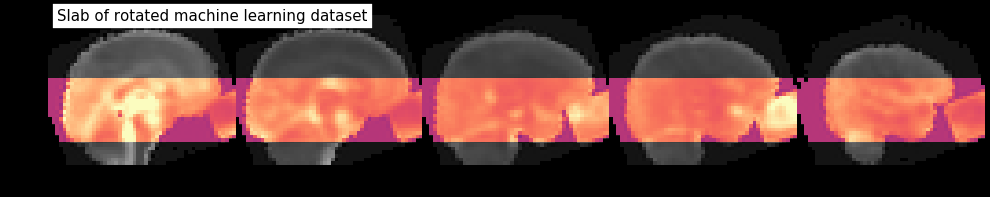

In [51]:
from nilearn.plotting import plot_stat_map
img_slab = img_rot.slicer[..., 6:24, :]
plot_stat_map(mean_img(img_slab), cmap='magma', bg_img=mean_img(img_rot), colorbar=False,
              display_mode='x', vmax=2, annotate=False, cut_coords=range(0, 49, 12),
              title='Slab of rotated machine learning dataset');

This should do the trick. Now we just have to extract the data from this slab:

In [52]:
data = np.rollaxis(img_slab.get_fdata(), 3, 0)[...,None]
data.shape

(384, 40, 51, 18, 1)

**Note:** We added another dimension to our array with `[...,None]`. This is needed for Keras and Tensorflow as this represents the channel dimension.

## Split data into a training and testing set

The splitting of the data into training and test set is exactly the same as before.

In [53]:
# Create list of indices and shuffle them
N = data.shape[0]
indices = np.arange(N)
np.random.shuffle(indices)

#  Cut the dataset at 80% to create the training and test set
N_80p = int(0.8 * N)
indices_train = indices[:N_80p]
indices_test = indices[N_80p:]

# Split the data into training and test sets
X_train = data[indices_train, ...]
X_test = data[indices_test, ...]

print(X_train.shape, X_test.shape)

(307, 40, 51, 18, 1) (77, 40, 51, 18, 1)


## Create outcome variable

Also here, everything is the same as in the 2D example.

In [54]:
y_train = labels[indices_train] == 'open'
y_test = labels[indices_test] == 'open'

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Creating a Sequential Model

So, first, let's again import the necessary modules. Notice that we swithced `Conv2D` and `MaxPooling2D` with their 3-dimensional counter part.

In [55]:
import tensorflow as tf
from keras.models import Sequential

from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization

from keras.optimizers import Adam, SGD

from keras import backend as K

Now, we need again to identify the important model parameters. In this case we need to extend the kernel size to 3 dimension:

In [112]:
# Get shape of input data
data_shape = tuple(X_train.shape[1:])

# Specify shape of convolution kernel
kernel_size = (2, 2, 2)

# Specify number of output categories
n_classes = 2

# Specify number of filters per layer
filters = 4

And we're good to go and can setup our model:

In [117]:
K.clear_session()
model = Sequential()

model.add(Conv3D(filters, kernel_size, activation='relu', input_shape=data_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D())

model.add(Conv3D(filters * 2, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D())

model.add(Conv3D(filters * 4, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D())

model.add(Conv3D(filters * 8, (2, 2, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 1)))

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(n_classes, activation='softmax'))

# optimizer
learning_rate = 1e-5
adam = Adam(lr=learning_rate)
sgd = SGD(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=adam, # swap out for sgd 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 39, 50, 17, 4)     36        
_________________________________________________________________
batch_normalization_1 (Batch (None, 39, 50, 17, 4)     16        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 19, 25, 8, 4)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 18, 24, 7, 8)      264       
_________________________________________________________________
batch_normalization_2 (Batch (None, 18, 24, 7, 8)      32        
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 9, 12, 3, 8)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 8, 11, 2, 16)      1040      
__________

## Fitting the Model

As before we need to specify how many epochs we want to run and what the batch size is. As you will see, the fitting of the 3D convoluted model takes much much longer than the one for the 2D model. Therefore we recommend to drastically decrease the number of epochs (at least for this workshop example).

In [110]:
nEpochs = 5
batch_size = 16

And we're good to go!

In [111]:
%time fit = model.fit(X_train, y_train, epochs=nEpochs, batch_size=batch_size)

Epoch 1/1
307/307 [==============================] - 11s 36ms/step - loss: 1.4154 - acc: 0.4951
CPU times: user 37.2 s, sys: 621 ms, total: 37.8 s
Wall time: 12 s


## Performance during model fitting

Let's take a look at the loss and accuracy values during the different epochs:

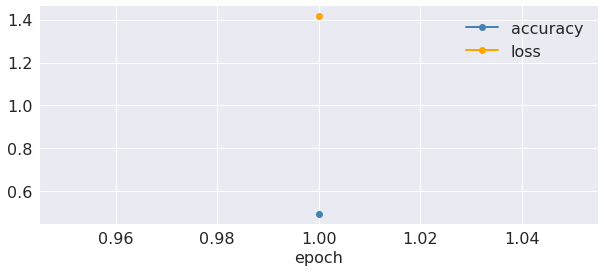

In [118]:
fig = plt.figure(figsize=(10, 4))
epoch = np.arange(nEpochs) + 1
fontsize = 16
plt.plot(epoch, fit.history['acc'], marker="o", linewidth=2,
         color="steelblue", label="accuracy")
plt.plot(epoch, fit.history['loss'], marker="o", linewidth=2,
         color="orange", label="loss")
plt.xlabel('epoch', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16);

## Evaluating the model

How about the performance on the test data?

In [119]:
evaluation = model.evaluate(X_test, y_test)
print('Loss in Test set:      %.02f' % (evaluation[0] * 100))
print('Accuracy in Test set:  %.02f' % (evaluation[1] * 100))

77/77 [==============================] - 1s 9ms/step
Loss in Test set:      69.30
Accuracy in Test set:  49.35


And we can look again at the prediction distribution:

In [120]:
y_pred = model.predict(X_test)
y_pred[:10,:]

array([[0.49282894, 0.50717103],
       [0.4937174 , 0.50628257],
       [0.49403542, 0.5059646 ],
       [0.4979638 , 0.5020362 ],
       [0.50011724, 0.4998827 ],
       [0.49899137, 0.5010087 ],
       [0.50327504, 0.496725  ],
       [0.4980865 , 0.5019135 ],
       [0.49380276, 0.5061973 ],
       [0.49463215, 0.5053679 ]], dtype=float32)

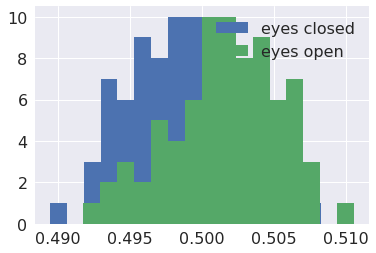

In [121]:
fig = plt.figure(figsize=(6, 4))
fontsize = 16
plt.hist(y_pred[:,0], bins=16, label='eyes closed')
plt.hist(y_pred[:,1], bins=16, label='eyes open');
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16);

## Visualizing Hidden Layers

Finally, let's try again to visualize the filters of the hidden layers. We need to change visualization a bit as it will be 3D objects this time:

In [122]:
# Aggregate the layers
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [138]:
first_layer_output = layer_dict['conv3d_1'].output
fn = K.function([model.input], [first_layer_output])
inp = X_train[0:1]
this_hidden = fn([inp])[0][0]

In [140]:
img_layer = nb.Nifti1Image(this_hidden, img_rot.affine, img_rot.header)

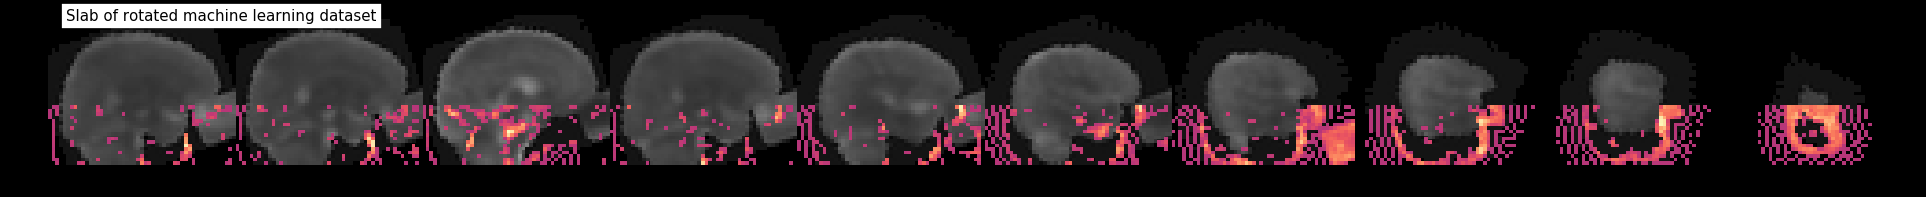

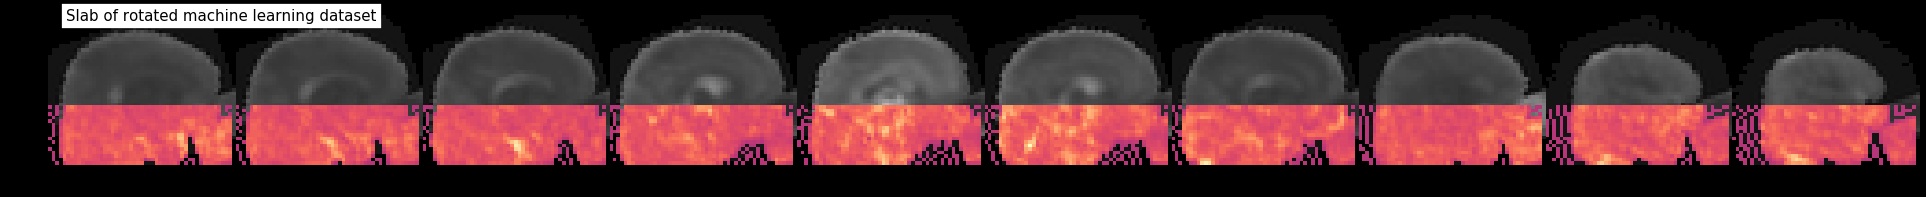

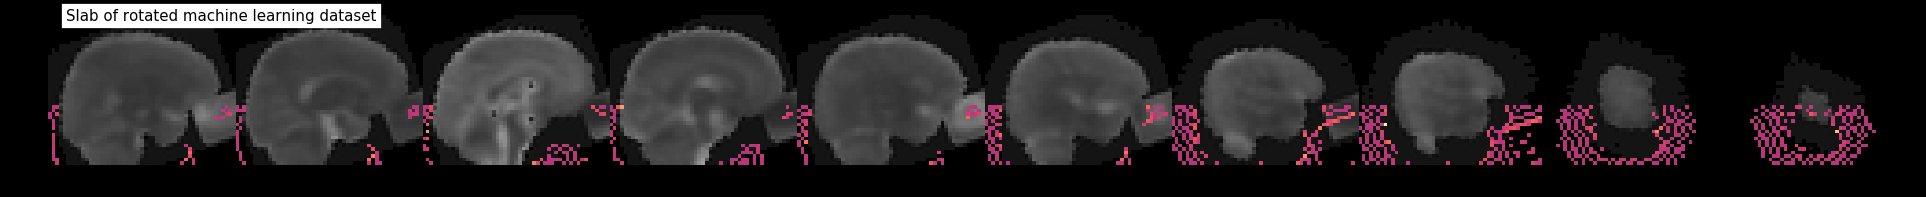

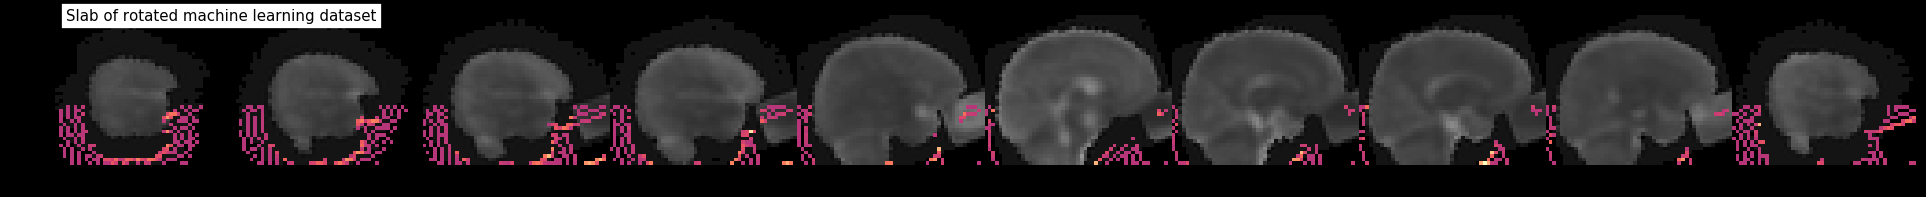

In [150]:
from nilearn.plotting import plot_stat_map
for i in range(img_layer.shape[-1]):
    plot_stat_map(img_layer.slicer[..., i], cmap='magma', bg_img=mean_img(img_rot), colorbar=False,
                  display_mode='x', annotate=False, cut_coords=10,
                  title='Slab of rotated machine learning dataset');

    subject = get_subject(0)

    print "Subject:", subject[0]

    X, Y = np.meshgrid(np.linspace(0,1,subject[1].shape[1]), np.linspace(0,1,subject[1].shape[2]))
    zlim = float(subject[1].shape[0] - 1)

    # create the figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlim((0.,zlim))
    ax.axis('off')
    ax.set_title("3D Projection.")

    for  i, d in enumerate(subject[1]):
        ax.contourf(X, Y, d, 100, zdir='z', offset=i, cmap=scan_cmap, aspect='equal')

    plt.show()